### HOG (Step.4) 特徴量の描画

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# get HOG step2
def HOG(img):
    # gray scale
    def BGR2GRAY(img):
        gray =  0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
        return gray
    
    # gx, gy
    def get_gradXY(gray):
        H,W = gray.shape
        

        gray = np.pad(gray, (1,1), 'edge')

        gx = gray[1:1+H, 2:] - gray[1:1+H, :W]
        gy = gray[2:, 1:1+W] - gray[:H, 1:1+W]
        gx[gx==0] = 1e-6
        
        return gx, gy
    
    
    
    
    # magunitude and angle
    def get_MagGrad(gx, gy):
        magunitude = np.sqrt(gx**2+gy**2)
        gradient = np.arctan(gy/gx)
        
        #gradient[gradient < 0] = np.pi/2 + gradient[gradient<0] +np.pi/2
        gradient[gradient < 0] = np.pi + gradient[gradient<0]
        
        return magunitude, gradient
    
    # quantization
    def quantization(gradient):
        # prepare quantization table
        gradient_quantized = np.zeros_like(gradient, dtype=np.int)
        
        # quantization base
        d = np.pi/9
        
        # quantization
        for i in range(9):
            gradient_quantized[np.where((gradient>=d*i)&(gradient<=d*(i+1)))] = i
            # これは両端気にしなくていいのか？
            
        return gradient_quantized
    
    # get gradient histogram
    def gradient_histogram(gradient_quantized, magunitude, N=8):
        # get shape
        H,W = magunitude.shape
        
        # get cell num
        cell_N_H = H//N
        cell_N_W = W//N
        histogram = np.zeros((cell_N_H, cell_N_W,9), dtype=np.float32)
        
        # each pixel
        for y in range(cell_N_H):
            for x in range(cell_N_W):
                for j in range(N):
                    for i in range(N):
                        # ？？？
                        histogram[y, x, gradient_quantized[y*8+j, x*8+i]] += magunitude[y*8+j, x*8+i]
        
        return histogram
    
    
    # histgram normalization
    def normalization(histogram, C=3, epsilon=1):
        cell_N_H, cell_N_W, _ = histogram.shape  # 32, 32, 9
        
        _C = C//2
        # each histogram
        for y in range(cell_N_H):
            for x in range(cell_N_W):
                histogram[y,x] /= np.sqrt(np.sum(histogram[max(y-1, 0):min(y+2, cell_N_H), \
                                                          max(x-1, 0):min(x+2, cell_N_W)]**2) +epsilon)
                
        return histogram
        
    def draw(gray, histogram, N=8):
        H,W = gray.shape
        cell_N_H, cell_N_W, _ = histogram.shape
        
        # draw
        out = gray[1:H+1, 1:W+1].copy().astype(np.uint8)
        
        for y in range(cell_N_H):
            for x in range(cell_N_W):
                cx = x*N+N//2
                cy = y*N+N//2
                x1 = cx + N//2 -1
                y1 = cy
                x2 = cx - N//2+1
                y2 = cy
                
                # ここなにしているかわからない
                h = histogram[y,x] / np.sum(histogram[y,x])
                h /= h.max()
                
                for c in range(9):
                    # めっちゃ効率悪い気がする
                    angle = (20*c+10) / 180.*np.pi
                    rx = int(np.sin(angle)*(x1-cx) + np.cos(angle)*(y1-cy)+cx)
                    ry = int(np.cos(angle)*(x1-cx) - np.cos(angle)*(y1-cy)+cy)
                    lx = int(np.sin(angle)*(x2-cx) + np.cos(angle)*(y2-cy)+cx)
                    ly = int(np.cos(angle)*(x2-cx) + np.cos(angle)*(y2-cy)+cy)
                    
                    # color is HOG value
                    c = int(255.*h[c])
                    
                    # draw line
                    cv2.line(out, (lx,ly),(rx,ry),(c,c,c), thickness=1)
                    
        return out 
        
    
    gray = BGR2GRAY(img)
    gx, gy = get_gradXY(gray)
    magunitude, gradient = get_MagGrad(gx, gy)
    gradient_quantized = quantization(gradient)
    histogram = gradient_histogram(gradient_quantized, magunitude)
    histogram = normalization(histogram)
    out = draw(gray, histogram)
    
    return out


True

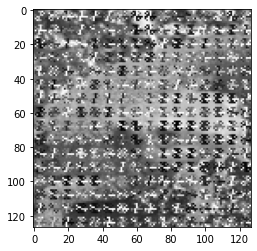

In [11]:
img = cv2.imread('../imori.jpg').astype(np.float32)
out = HOG(img)

plt.imshow(out, cmap='gray')
cv2.imwrite('out69.jpg', out)